In [26]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [27]:
# ============ РАСПАКОВКА АРХИВА ============
zip_path = "dataset.zip"   # путь до архива
extract_dir = "dataset"    # папка, куда распакуем

if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

# Ожидается структура:
# dataset/train/normal, dataset/train/Nenormal
# dataset/val/normal, dataset/val/Nenormal
# dataset/test/normal, dataset/test/Nenormal

In [28]:
# ============ ПАРАМЕТРЫ ============
batch_size = 32
num_classes = 2
epochs = 9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============ ПРЕОБРАЗОВАНИЯ ============
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # ч/б
    transforms.Resize((28, 28)),                 # под DNDF
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [29]:
# ============ ДАТАСЕТЫ ============
train_dataset = ImageFolder(os.path.join(extract_dir, "train"), transform=transform)
val_dataset   = ImageFolder(os.path.join(extract_dir, "valid"), transform=transform)
test_dataset  = ImageFolder(os.path.join(extract_dir, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
# ============ DNDF МОДЕЛЬ ============
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(32*5*5, 64)  # для 28x28 → 32*5*5

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [31]:
class DecisionNode(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.fc = nn.Linear(in_features, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

In [32]:
class Leaf(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.probs = nn.Parameter(torch.ones(n_classes) / n_classes)

    def forward(self, batch_size):
        return self.probs.unsqueeze(0).repeat(batch_size, 1)

In [33]:
class DNDFTree(nn.Module):
    def __init__(self, in_features, n_classes=2):
        super().__init__()
        self.node1 = DecisionNode(in_features)
        self.node2 = DecisionNode(in_features)
        self.leaf1 = Leaf(n_classes)
        self.leaf2 = Leaf(n_classes)
        self.leaf3 = Leaf(n_classes)
        self.leaf4 = Leaf(n_classes)

    def forward(self, x):
        batch_size = x.size(0)
        p1 = self.node1(x)
        p2 = self.node2(x)

        path1 = (1 - p1) * (1 - p2)
        path2 = (1 - p1) * p2
        path3 = p1 * (1 - p2)
        path4 = p1 * p2

        out = (
            path1 * self.leaf1(batch_size) +
            path2 * self.leaf2(batch_size) +
            path3 * self.leaf3(batch_size) +
            path4 * self.leaf4(batch_size)
        )
        return out

In [34]:
class DNDF(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.feature_extractor = FeatureExtractor()
        self.tree = DNDFTree(64, n_classes)

    def forward(self, x):
        feats = self.feature_extractor(x)
        return self.tree(feats)

In [35]:
# ============ ОБУЧЕНИЕ ============
model = DNDF(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    # ---- train ----
    model.train()
    correct, total, train_loss = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        correct += (preds.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = correct / total
    # ---- validation ----
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = criterion(preds, labels)

            val_loss += loss.item() * imgs.size(0)
            correct += (preds.argmax(1) == labels).sum().item()
            total += labels.size(0)

    val_loss /= total
    val_acc = correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train loss {train_loss:.4f}, acc {train_acc:.4f} | Val loss {val_loss:.4f}, acc {val_acc:.4f}")


Epoch 1/9 | Train loss 0.6884, acc 0.7586 | Val loss 0.6802, acc 0.8194
Epoch 2/9 | Train loss 0.6766, acc 0.7586 | Val loss 0.6637, acc 0.8194
Epoch 3/9 | Train loss 0.6601, acc 0.7586 | Val loss 0.6423, acc 0.9444
Epoch 4/9 | Train loss 0.6406, acc 0.9266 | Val loss 0.6211, acc 0.9861
Epoch 5/9 | Train loss 0.6224, acc 0.9331 | Val loss 0.6014, acc 0.9861
Epoch 6/9 | Train loss 0.6056, acc 0.9331 | Val loss 0.5832, acc 0.9861
Epoch 7/9 | Train loss 0.5899, acc 0.9331 | Val loss 0.5660, acc 0.9861
Epoch 8/9 | Train loss 0.5751, acc 0.9331 | Val loss 0.5499, acc 0.9861
Epoch 9/9 | Train loss 0.5616, acc 0.9331 | Val loss 0.5371, acc 0.9861


In [36]:
# ============ СОХРАНЕНИЕ ============
torch.save(model.state_dict(), "dndf_weights.pth")
print("Модель сохранена в dndf_weights.pth")

Модель сохранена в dndf_weights.pth


In [37]:
train_losses, val_losses, test_losses = [], [], []
train_accs, val_accs, test_accs = [], [], []

for epoch in range(epochs):
    # ---- train ----
    model.train()
    correct, total, train_loss = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        correct += (preds.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = correct / total

    # ---- validation ----
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = criterion(preds, labels)
            val_loss += loss.item() * imgs.size(0)
            correct += (preds.argmax(1) == labels).sum().item()
            total += labels.size(0)

    val_loss /= total
    val_acc = correct / total

    # ---- test ----
    correct, total, test_loss = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = criterion(preds, labels)
            test_loss += loss.item() * imgs.size(0)
            correct += (preds.argmax(1) == labels).sum().item()
            total += labels.size(0)

    test_loss /= total
    test_acc = correct / total

    # сохраняем всё
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train loss {train_loss:.4f}, acc {train_acc:.4f} | "
          f"Val loss {val_loss:.4f}, acc {val_acc:.4f} | "
          f"Test loss {test_loss:.4f}, acc {test_acc:.4f}")

Epoch 1/9 | Train loss 0.5484, acc 0.9347 | Val loss 0.5271, acc 0.9722 | Test loss 0.5205, acc 0.9873
Epoch 2/9 | Train loss 0.5335, acc 0.9396 | Val loss 0.5086, acc 0.9722 | Test loss 0.5001, acc 1.0000
Epoch 3/9 | Train loss 0.5221, acc 0.9364 | Val loss 0.4965, acc 0.9722 | Test loss 0.4853, acc 1.0000
Epoch 4/9 | Train loss 0.5092, acc 0.9396 | Val loss 0.4807, acc 0.9861 | Test loss 0.4714, acc 1.0000
Epoch 5/9 | Train loss 0.4964, acc 0.9429 | Val loss 0.4714, acc 0.9722 | Test loss 0.4582, acc 1.0000
Epoch 6/9 | Train loss 0.4849, acc 0.9445 | Val loss 0.4575, acc 0.9722 | Test loss 0.4456, acc 1.0000
Epoch 7/9 | Train loss 0.4749, acc 0.9396 | Val loss 0.4502, acc 0.9722 | Test loss 0.4395, acc 0.9968
Epoch 8/9 | Train loss 0.4625, acc 0.9462 | Val loss 0.4312, acc 0.9861 | Test loss 0.4220, acc 1.0000
Epoch 9/9 | Train loss 0.4527, acc 0.9445 | Val loss 0.4200, acc 0.9861 | Test loss 0.4104, acc 1.0000


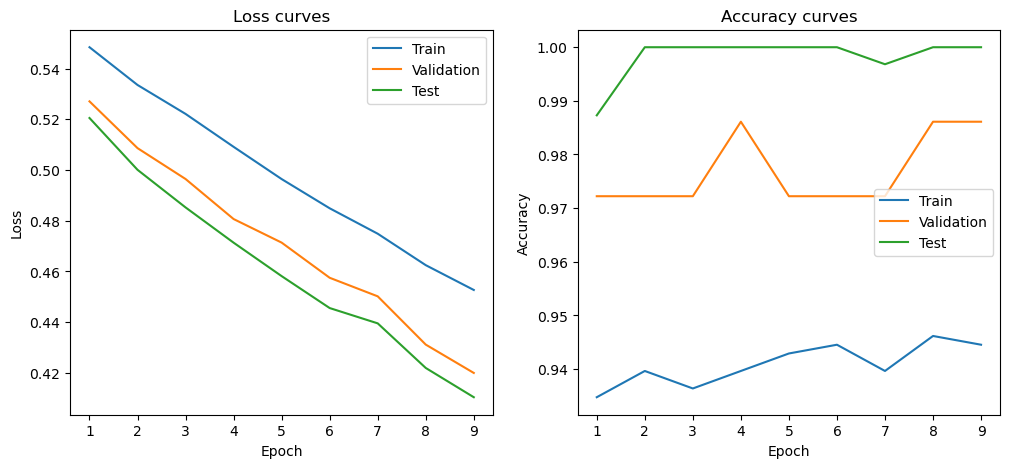

In [38]:
epochs_range = range(1, epochs+1)

plt.figure(figsize=(12,5))

# --- Loss ---
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label="Train")
plt.plot(epochs_range, val_losses, label="Validation")
plt.plot(epochs_range, test_losses, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss curves")
plt.legend()

# --- Accuracy ---
plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs, label="Train")
plt.plot(epochs_range, val_accs, label="Validation")
plt.plot(epochs_range, test_accs, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy curves")
plt.legend()

plt.show()